# Otimização com Algoritmos Genéticos

Neste notebook, exploramos a aplicação de *Algoritmos Genéticos (AGs)* para resolver problemas de otimização unidimensional. Através de duas implementações distintas — uma manual e outra utilizando a biblioteca **DEAP** *(Distributed Evolutionary Algorithms in Python)* — investigamos o comportamento e a eficiência dos AGs na busca pela melhor solução de uma função real.

## Implementações

### Implementação sem uso de libraries

Nesta implementação, utilizamos recombinação e mutação simplificadas, veja as descrições após o código.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable

def run_ga(
    function: Callable[[float], float],
    interval: tuple[float, float] = (-20, 20),
    pop_size: int = 30,
    gen_number: int = 6,
    mutation_rate: float = 0.1,
    crossover_rate: float = 0.8,
    elitism: int = 0,
) -> None:
    # Limites do intervalo
    LOW, HIGH = interval

    # Função de fitness (valor da função)
    def fitness(individual: float) -> float:
        return function(individual)

    # Seleção por torneio
    def tournament_selection(
        population: np.ndarray, fitness_values: np.ndarray, k: int = 3
    ) -> float:
        selected_indices = np.random.choice(len(population), size=k, replace=False)
        selected_fitness = fitness_values[selected_indices]
        winner_index = selected_indices[np.argmax(selected_fitness)]
        return population[winner_index]

    # Crossover (combinação de dois pais)
    def crossover(parent1: float, parent2: float) -> float:
        if np.random.rand() < crossover_rate:
            alpha = np.random.rand()  # Fator de mistura
            child = alpha * parent1 + (1 - alpha) * parent2
        else:
            child = parent1  # Sem crossover, retorna o primeiro pai
        return child

    # Mutação (perturbação aleatória)
    def mutate(individual: float) -> float:
        if np.random.rand() < mutation_rate:
            individual += np.random.uniform(-1, 1)  # Perturbação aleatória
            individual = np.clip(individual, LOW, HIGH)  # Garantir que está dentro dos limites
        return individual

    # Inicialização da população
    population: np.ndarray = np.random.uniform(LOW, HIGH, size=(pop_size,))

    # Evolução
    best_fitness_history: list[float] = []
    population_history: list[np.ndarray] = []  # Para armazenar as populações de cada geração

    for generation in range(gen_number):
        # Avaliar fitness da população
        fitness_values: np.ndarray = np.array([fitness(ind) for ind in population])

        # Guardar o histórico de fitness
        best_index: int = np.argmax(fitness_values)
        best_individual: float = population[best_index]
        best_fitness: float = fitness_values[best_index]
        best_fitness_history.append(best_fitness)

        # Armazenar a população atual para visualização
        population_history.append(population.copy())

        # Seleção, crossover e mutação
        new_population: list[float] = []

        # Elitismo: manter os melhores indivíduos
        tmp: np.ndarray = fitness_values.copy()
        for _ in range(elitism):
            best_index = np.argmax(tmp)
            best_individual = population[best_index]
            tmp[best_index] = -np.inf
            new_population.append(best_individual)

        # Gerar nova população
        while len(new_population) < pop_size:
            # Selecionar dois pais
            parent1: float = tournament_selection(population, fitness_values)
            parent2: float = tournament_selection(population, fitness_values)

            # Crossover
            child: float = crossover(parent1, parent2)

            # Mutação
            child = mutate(child)

            # Adicionar à nova população
            new_population.append(child)

        # Atualizar população
        population = np.array(new_population)

    # Resultado final
    best_index: int = np.argmax([fitness(ind) for ind in population])
    best_solution: float = population[best_index]
    best_fitness: float = fitness(best_solution)

    print(f"Melhor solução encontrada: x = {best_solution}, f(x) = {best_fitness}")

    # Plotar as populações em gráficos (3 gráficos por linha, 2 linhas)
    plt.figure(figsize=(18, 12))
    x_vals: np.ndarray = np.linspace(LOW, HIGH, 1000)
    y_vals: np.ndarray = function(x_vals)

    for generation in range(gen_number):
        plt.subplot(2, 3, generation + 1)  # 2 linhas, 3 colunas
        plt.plot(x_vals, y_vals, label='Função', color='blue')
        plt.scatter(
            population_history[generation], function(population_history[generation]), color='red', label='População'
        )
        plt.title(f'Geração {generation + 1}')
        plt.xlabel('x')
        plt.ylabel('f(x)')
        plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
        plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
        plt.grid(True)
        plt.legend()

    plt.tight_layout()
    plt.show()

    # Plotar a evolução do fitness
    plt.figure(figsize=(10, 6))
    plt.plot(best_fitness_history, label='Melhor Fitness por Geração', color='green')
    plt.title('Evolução do Fitness')
    plt.xlabel('Geração')
    plt.ylabel('Melhor Fitness')
    plt.grid(True)
    plt.legend()
    plt.show()

#### 📌 **Descrição `run_ga`**

**1. Definições iniciais**

- **Função objetivo (fitness)**:
  $$
  f: \mathbb{R} \to \mathbb{R}, \quad \text{a ser maximizada.}
  $$

- **Intervalo de busca**:
  $$
  I = [L, H] \subset \mathbb{R}, \quad \text{com } L = -20, \, H = 20.
  $$

- **Tamanho da população**: $N \in \mathbb{N}$

- **Número de gerações**: $G \in \mathbb{N}$

- **Taxa de crossover**: $p_c \in [0,1]$

- **Taxa de mutação**: $p_m \in [0,1]$

- **Elitismo**: $e \in \mathbb{N}$, número de melhores indivíduos copiados diretamente para a próxima geração.


**2. Inicialização da população**

Geramos $N$ indivíduos $\{x_1^0, x_2^0, \dots, x_N^0\} \subset [L, H]$ tais que:

$$
x_i^0 \sim \mathcal{U}(L, H).
$$


**3. Avaliação do fitness**

Para cada indivíduo $x_i^t$, calculamos:

$$
f_i^t = f(x_i^t).
$$


**4. Seleção por torneio (k = 3)**

Para selecionar um indivíduo:
1. Amostram-se 3 indivíduos aleatoriamente da população.
2. Seleciona-se aquele com o maior valor de fitness.

Formalmente, dado um conjunto $S \subset \{1, \dots, N\}$, com $|S| = 3$:

$$
x_{\text{sel}} = \arg\max_{i \in S} f(x_i).
$$


**5. Crossover linear (recombinação)**

Dado dois pais $x_1, x_2 \in \mathbb{R}$, um novo indivíduo $x_{\text{child}}$ é gerado por:

$$
x_{\text{child}} = 
\begin{cases}
\alpha x_1 + (1 - \alpha)x_2, & \text{com probabilidade } p_c, \\
x_1, & \text{com probabilidade } 1 - p_c.
\end{cases}
\quad \text{onde } \alpha \sim \mathcal{U}(0, 1)
$$


**6. Mutação aditiva**

Dado um indivíduo $x \in \mathbb{R}$, aplica-se:

$$
x' = 
\begin{cases}
x + \delta, & \text{com probabilidade } p_m, \\
x, & \text{com probabilidade } 1 - p_m.
\end{cases}
\quad \text{onde } \delta \sim \mathcal{U}(-1, 1)
$$

E então:

$$
x' \leftarrow \text{clip}(x', L, H)
$$


**7. Elitismo**

Os $e$ indivíduos com maior fitness na geração $t$ são transferidos diretamente para $t+1$:

$$
x_1^{t+1}, x_2^{t+1}, \dots, x_e^{t+1} \in \arg\max_{x \in \{x_i^t\}} f(x).
$$


**8. Iteração**

Os passos 3 a 7 são repetidos por $G$ gerações, produzindo uma nova população a cada iteração.


**9. Resultado final**

Ao final da última geração $G$, retorna-se:

$$
x^* = \arg\max_{x \in \{x_i^G\}} f(x).
$$

### Implementação com uso da library DEAP

Nesta implementação, seguimos o mesmo fluxo proposto na anterior, porém, utilizando operadores de recombinação e mutação um pouco mais sofisticados.

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, tools
from typing import Callable

def run_ga_deap(
    function: Callable[[float], float],
    interval: tuple[float, float] = (-20, 20),
    pop_size: int = 30,
    gen_number: int = 6,
    mutation_rate: float = 0.1,
    crossover_rate: float = 0.8,
    elitism: int = 0,
) -> None:
    # Limites do intervalo
    LOW, HIGH = interval
    
    # Resetar o criador para evitar erros ao executar a função múltiplas vezes
    if hasattr(creator, "FitnessMax"):
        del creator.FitnessMax
    if hasattr(creator, "Individual"):
        del creator.Individual
    
    # Definir tipos de indivíduos e populações
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Maximizar a função
    creator.create("Individual", list, fitness=creator.FitnessMax)

    # Inicializar a toolbox
    toolbox = base.Toolbox()
    
    # Registrar funções para criar indivíduos e população
    toolbox.register("attr_float", random.uniform, LOW, HIGH)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, 1)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    # Função de fitness (valor da função)
    def fitness_func(individual):
        return function(individual[0]),  # DEAP requer que a função de fitness retorne uma tupla

    # Registrar operadores genéticos
    toolbox.register("evaluate", fitness_func)
    toolbox.register("mate", tools.cxBlend, alpha=0.5)  # Crossover blend
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=(HIGH-LOW)/10, indpb=1.0)
    toolbox.register("select", tools.selTournament, tournsize=3)

    # Criar população inicial
    population = toolbox.population(n=pop_size)
    
    # Avaliar a população inicial
    fitnesses = list(map(toolbox.evaluate, population))
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit
    
    # Hall of Fame para elitismo (só criar se realmente precisar)
    hof = tools.HallOfFame(max(1, elitism)) if elitism > 0 else None
    
    # Histórico para visualização
    best_fitness_history = []
    population_history = []

    # Evolução
    for gen in range(gen_number):
        # Armazenar população para visualização
        population_history.append([ind[0] for ind in population])
        
        # Encontrar o melhor indivíduo desta geração
        best_ind = tools.selBest(population, 1)[0]
        best_fitness_history.append(best_ind.fitness.values[0])
        
        # Atualizar Hall of Fame (apenas se estiver usando elitismo)
        if hof is not None:
            hof.update(population)
        
        # Selecionar indivíduos para a próxima geração
        offspring = toolbox.select(population, pop_size)
        offspring = list(map(toolbox.clone, offspring))
        
        # Aplicar crossover
        for i in range(0, len(offspring), 2):
            if i + 1 < len(offspring) and random.random() < crossover_rate:
                toolbox.mate(offspring[i], offspring[i + 1])
                del offspring[i].fitness.values
                del offspring[i + 1].fitness.values

        # Aplicar mutação
        for i in range(len(offspring)):
            if random.random() < mutation_rate:
                toolbox.mutate(offspring[i])
                del offspring[i].fitness.values
        
        # Garantir que os indivíduos estejam dentro dos limites
        for ind in offspring:
            if not ind.fitness.valid:
                ind[0] = np.clip(ind[0], LOW, HIGH)
        
        # Avaliar os indivíduos com fitness inválido
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        
        # Substituir a população considerando o elitismo
        if elitism > 0 and hof is not None:
            # Substituir os piores indivíduos pelos elites
            offspring.sort(key=lambda ind: ind.fitness.values[0])
            for i in range(min(len(hof), elitism)):
                if i < len(offspring):
                    offspring[i] = toolbox.clone(hof[i])
        
        # Substituir a população
        population[:] = offspring
    
    # Obter o melhor indivíduo
    best_ind = tools.selBest(population, 1)[0]
    best_solution = best_ind[0]
    best_fitness = best_ind.fitness.values[0]
    
    print(f"Melhor solução encontrada: x = {best_solution}, f(x) = {best_fitness}")

    # Plotar as populações em gráficos (3 gráficos por linha, 2 linhas)
    plt.figure(figsize=(18, 12))
    x_vals = np.linspace(LOW, HIGH, 1000)
    y_vals = function(x_vals)

    for generation in range(gen_number):
        plt.subplot(2, 3, generation + 1)  # 2 linhas, 3 colunas
        plt.plot(x_vals, y_vals, label='Função', color='blue')
        plt.scatter(
            population_history[generation], 
            function(np.array(population_history[generation])), 
            color='red', 
            label='População'
        )
        plt.title(f'Geração {generation + 1}')
        plt.xlabel('x')
        plt.ylabel('f(x)')
        plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
        plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
        plt.grid(True)
        plt.legend()

    plt.tight_layout()
    plt.show()

    # Plotar a evolução do fitness
    plt.figure(figsize=(10, 6))
    plt.plot(best_fitness_history, label='Melhor Fitness por Geração', color='green')
    plt.title('Evolução do Fitness')
    plt.xlabel('Geração')
    plt.ylabel('Melhor Fitness')
    plt.grid(True)
    plt.legend()
    plt.show()

#### 📌 **Descrição `run_ga_deap`**

**1. Definições iniciais**

- **Função objetivo (fitness)**:
  $$
  f: \mathbb{R} \to \mathbb{R}, \quad \text{a ser maximizada.}
  $$

- **Intervalo de busca**:
  $$
  I = [L, H] \subset \mathbb{R}, \quad \text{com } L = -20, \, H = 20.
  $$

- **Tamanho da população**: $N \in \mathbb{N}$

- **Número de gerações**: $G \in \mathbb{N}$

- **Taxa de crossover**: $p_c \in [0,1]$

- **Taxa de mutação**: $p_m \in [0,1]$

- **Elitismo**: $e \in \mathbb{N}$, número de melhores indivíduos preservados entre gerações.


**2. Inicialização da população**

Geramos $N$ indivíduos $\{x_1^0, x_2^0, \dots, x_N^0\} \subset [L, H]$ tais que:

$$
x_i^0 \sim \mathcal{U}(L, H)
$$


**3. Avaliação do fitness**

Para cada indivíduo $x_i^t$, computa-se:

$$
f_i^t = f(x_i^t)
$$


**4. Seleção por torneio (k = 3)**

Para gerar a próxima geração, aplica-se seleção por torneio:

1. Selecionam-se aleatoriamente 3 indivíduos da população.
2. O indivíduo com maior fitness é escolhido.

Formalmente, para um subconjunto $S \subset \{1, \dots, N\}$ com $|S| = 3$:

$$
x_{\text{sel}} = \arg\max_{i \in S} f(x_i)
$$


**5. Crossover blend**

Dado dois indivíduos $x_1, x_2 \in \mathbb{R}$, o cruzamento blend (com $\alpha = 0.5$ fixo) gera dois descendentes:

Primeiramente, geramos o parâmetro de mistura $\gamma:=(1+2\alpha)*r-\alpha$, sendo $r~\mathcal{U}$.

$$
\begin{aligned}
x_{\text{child1}} &= \gamma x_1 + (1 - \gamma)x_2, \\
x_{\text{child2}} &= \gamma x_2 + (1 - \gamma)x_1,
\end{aligned}
$$

Este cruzamento é aplicado com probabilidade $p_c$ para cada par de indivíduos. Nesta implementação fixamos $\alpha=0.5$.


**6. Mutação Gaussiana**

Cada indivíduo $x$ sofre mutação com probabilidade $p_m$, sendo perturbado por ruído gaussiano:

$$
x' = x + \delta, \quad \delta \sim \mathcal{N}(0, \sigma^2)
$$

onde $\sigma = \dfrac{H - L}{10}$. Após a mutação:

$$
x' \leftarrow \text{clip}(x', L, H)
$$


**7. Elitismo**

Os $e$ melhores indivíduos da população anterior (com maior valor de $f$) são transferidos diretamente para a nova população, substituindo os piores indivíduos gerados:

$$
x_1^{t+1}, x_2^{t+1}, \dots, x_e^{t+1} \in \arg\max_{x \in \{x_i^t\}} f(x)
$$


**8. Iteração**

Os passos 3 a 7 são repetidos por $G$ gerações, produzindo uma nova população a cada iteração.


**9. Resultado final**

Ao final da geração $G$, retorna-se o melhor indivíduo da última população:

$$
x^* = \arg\max_{x \in \{x_i^G\}} f(x)
$$

## Execução dos Testes

### Função Sinc

A função objetivo considerada é:

$$
f(x)=\text{sinc}(x):=\begin{cases}
\frac{\sin(x)/x}, &\text{se } x\neq 0, \\
0, &\text{se }x=0.
\end{cases}
$$

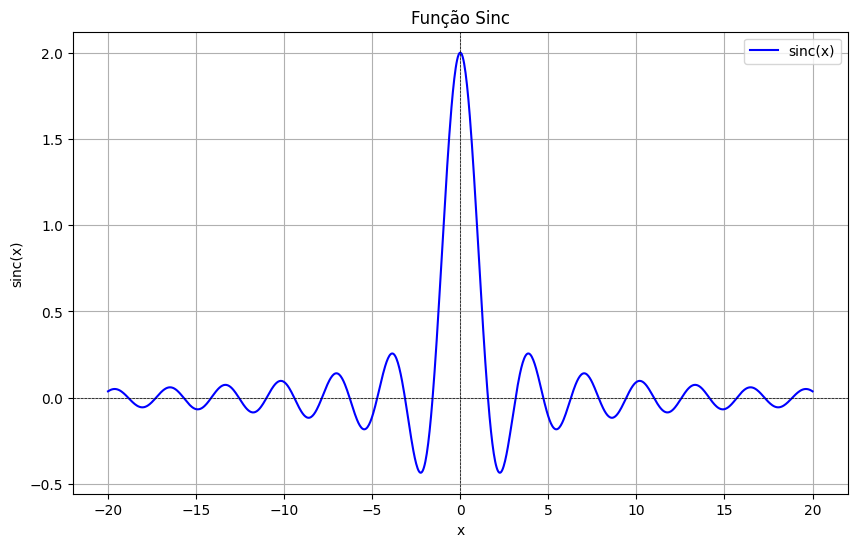

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Definição da função sinc
def sinc(x):
    # Evitar divisão por zero
    return np.where(x == 0, 1.0, np.sin(2*x) / x)

# Criar um array de valores de x
x = np.linspace(-20, 20, 1000)  # Valores de x de -20 a 20 com 1000 pontos

# Calcular os valores de sinc(x)
y = sinc(x)

# Plotar a função sinc
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='sinc(x)', color='blue')
plt.title('Função Sinc')
plt.xlabel('x')
plt.ylabel('sinc(x)')
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')  # Linha horizontal em y=0
plt.axvline(0, color='black', linewidth=0.5, linestyle='--')  # Linha vertical em x=0
plt.grid(True)
plt.legend()
plt.show()

Implementação Simplificada
Melhor solução encontrada: x = 0.0003618298911303642, f(x) = 1.9999998254388442


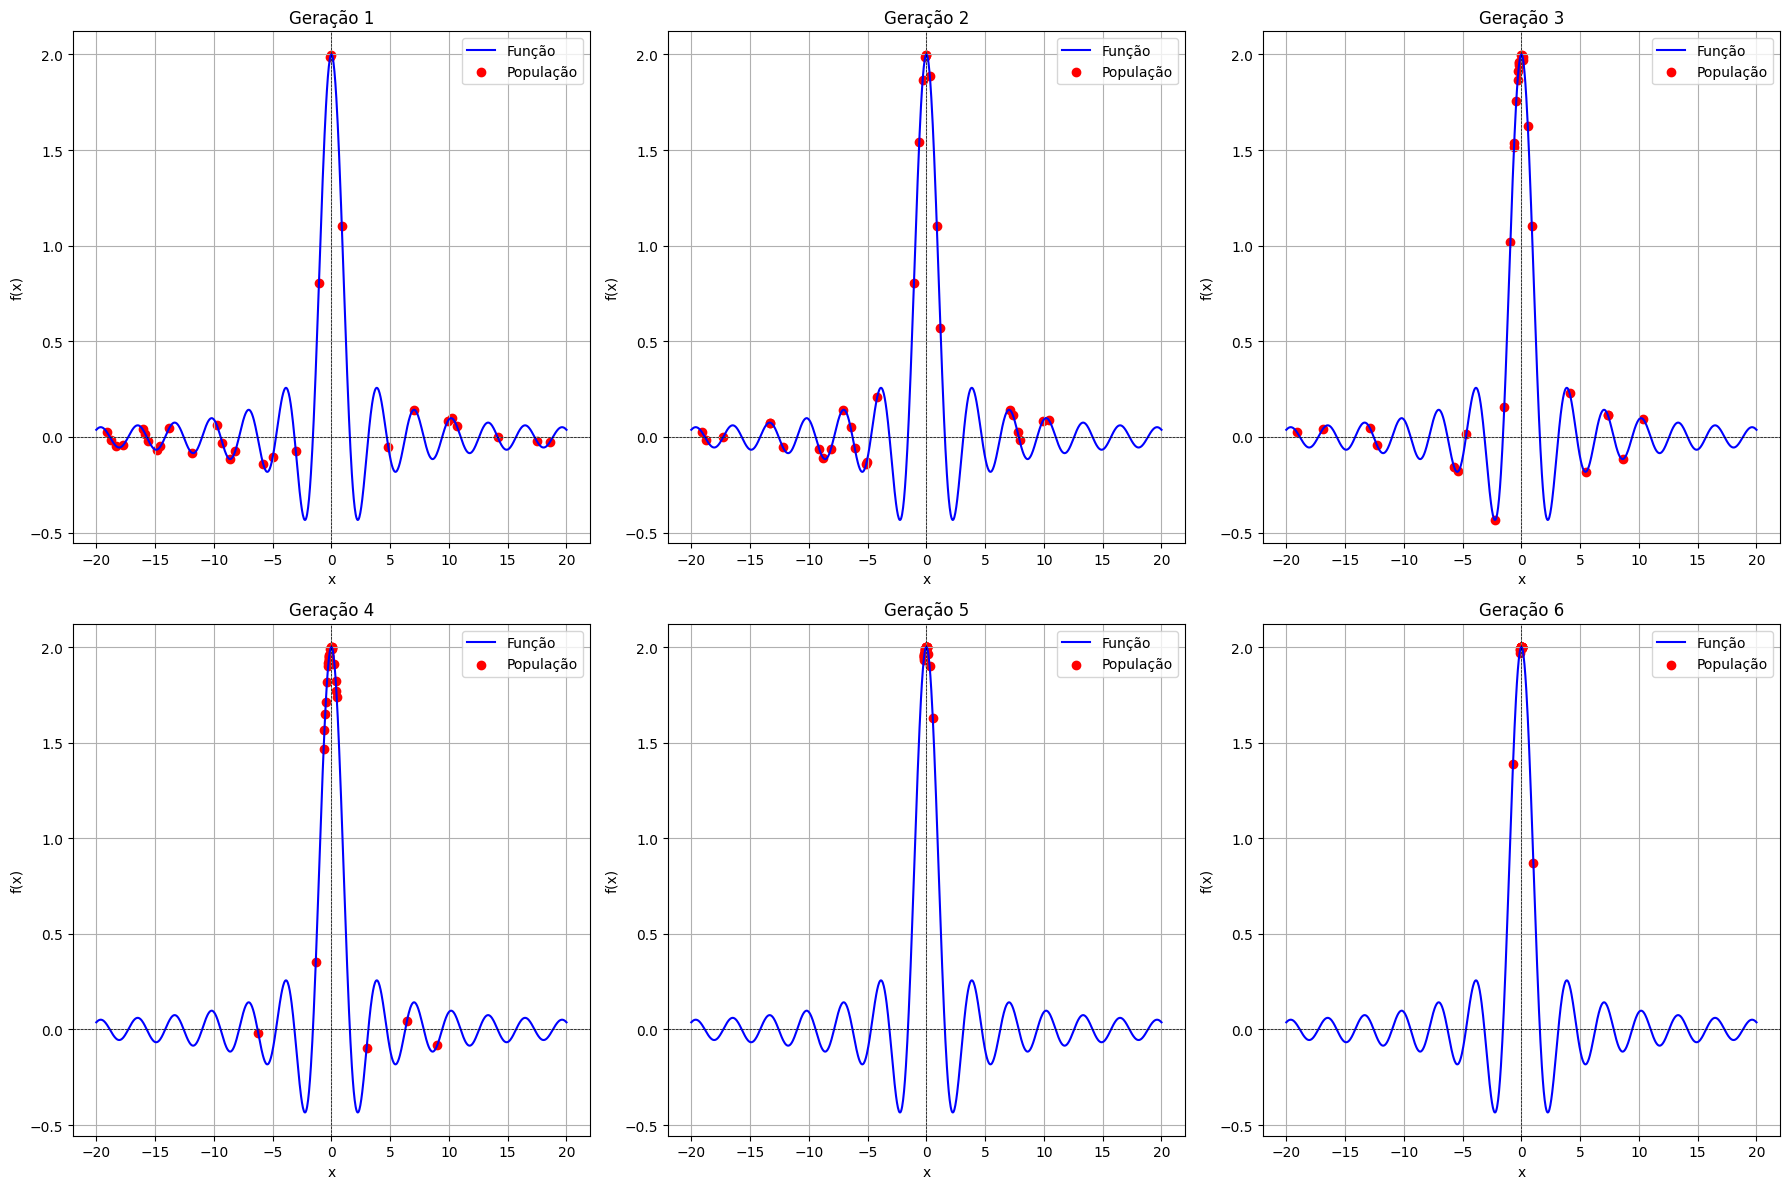

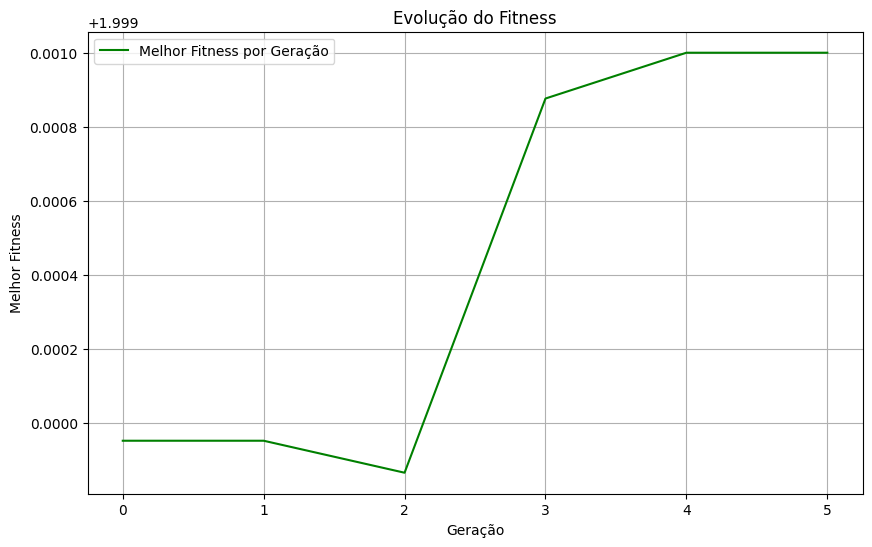

Implementação com Library DEAP
Melhor solução encontrada: x = -0.007252742287807361, f(x) = 1.999929864376938


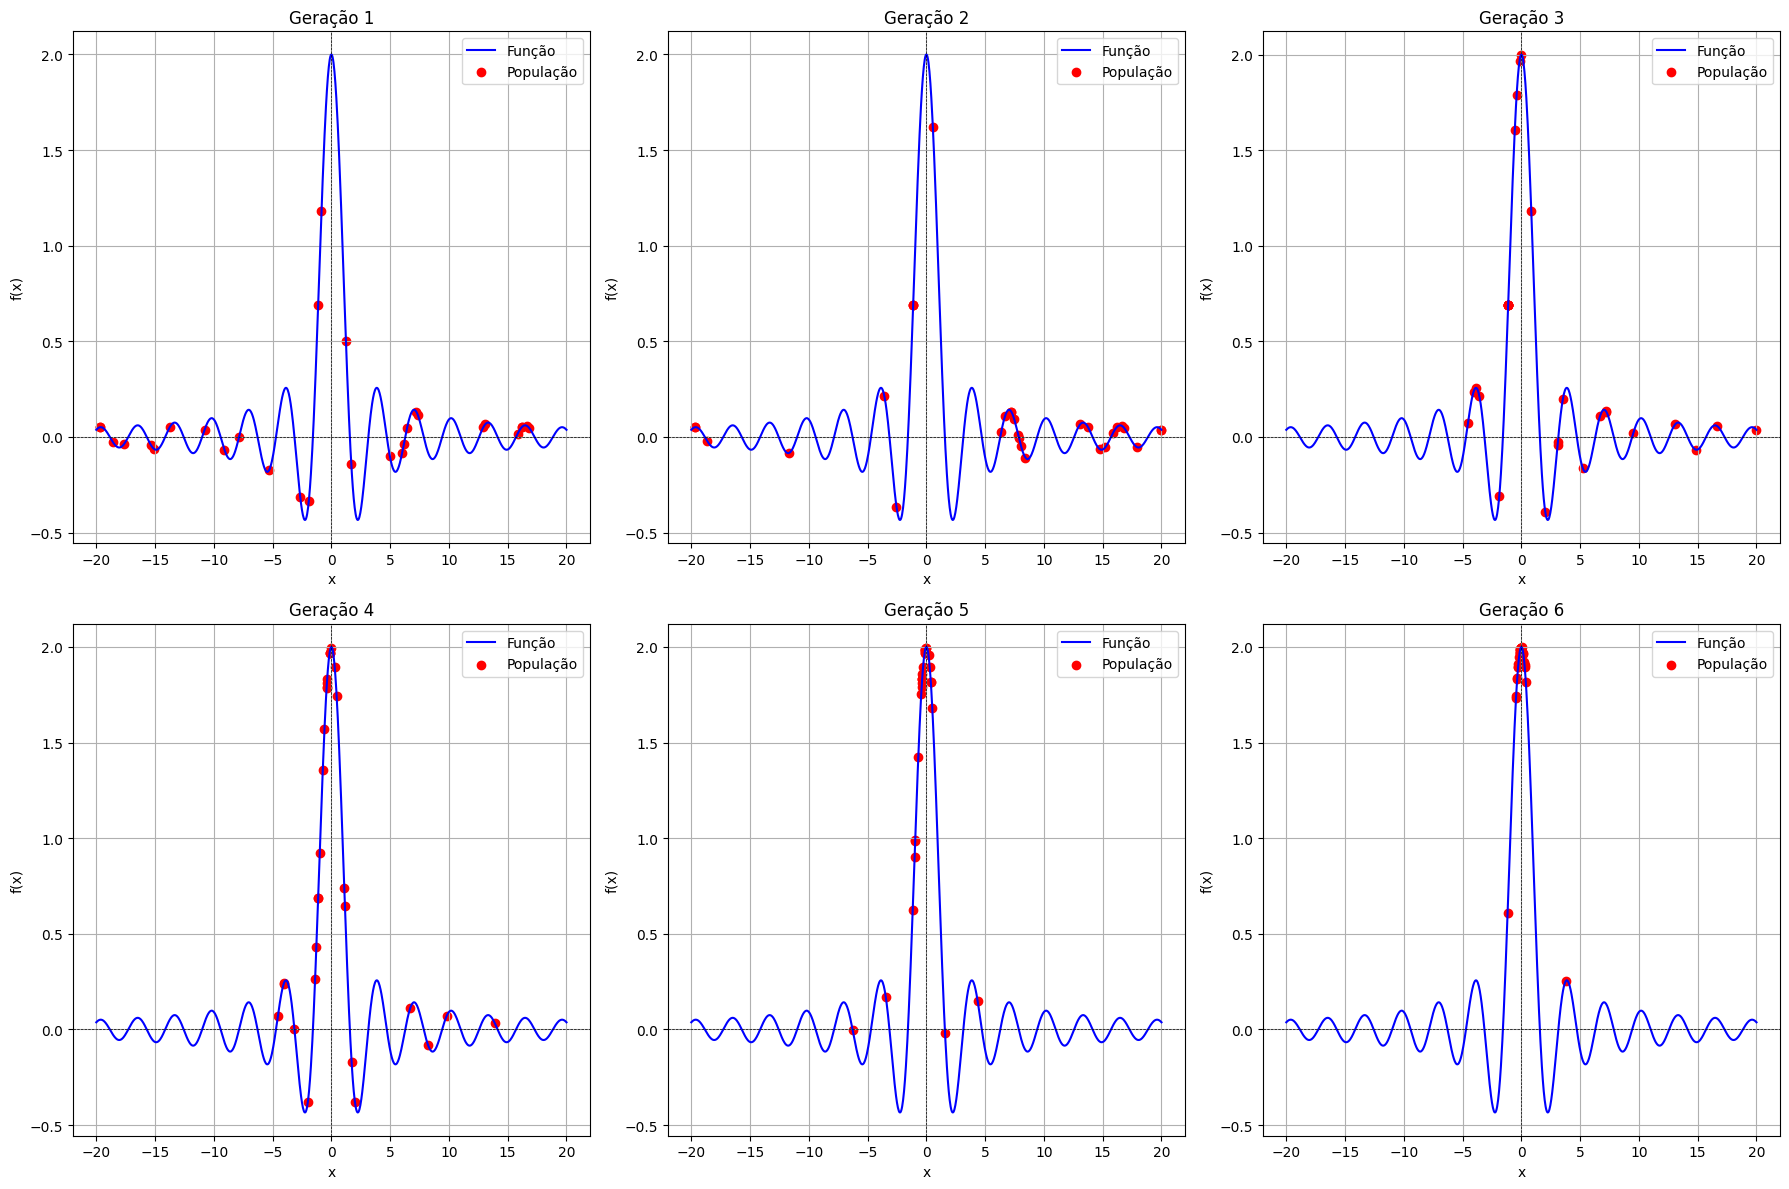

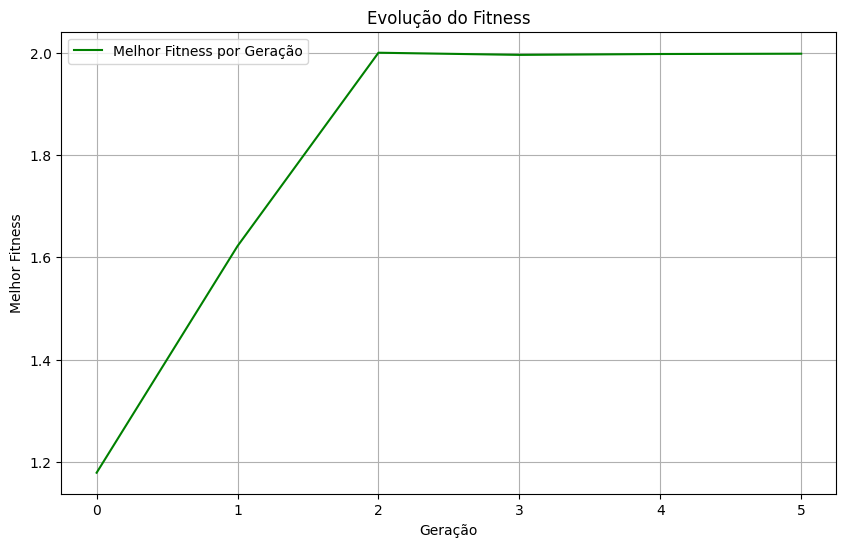

In [4]:
print("Implementação Simplificada")
run_ga(function=sinc, interval=[-20, 20])

print("Implementação com Library DEAP")
run_ga_deap(function=sinc, interval=[-20, 20])

### Função Dupla Sinc

$$
f(x) = \text{sinc}(x-10) + \text{sinc}(x+10)
$$

Essa função apresenta dois picos principais, tornando-se um bom exemplo para analisar a **exploração** e a **exploração local** em algoritmos evolutivos.

Implementação Simplificada
Melhor solução encontrada: x = 9.974749283895123, f(x) = 2.038090651268325


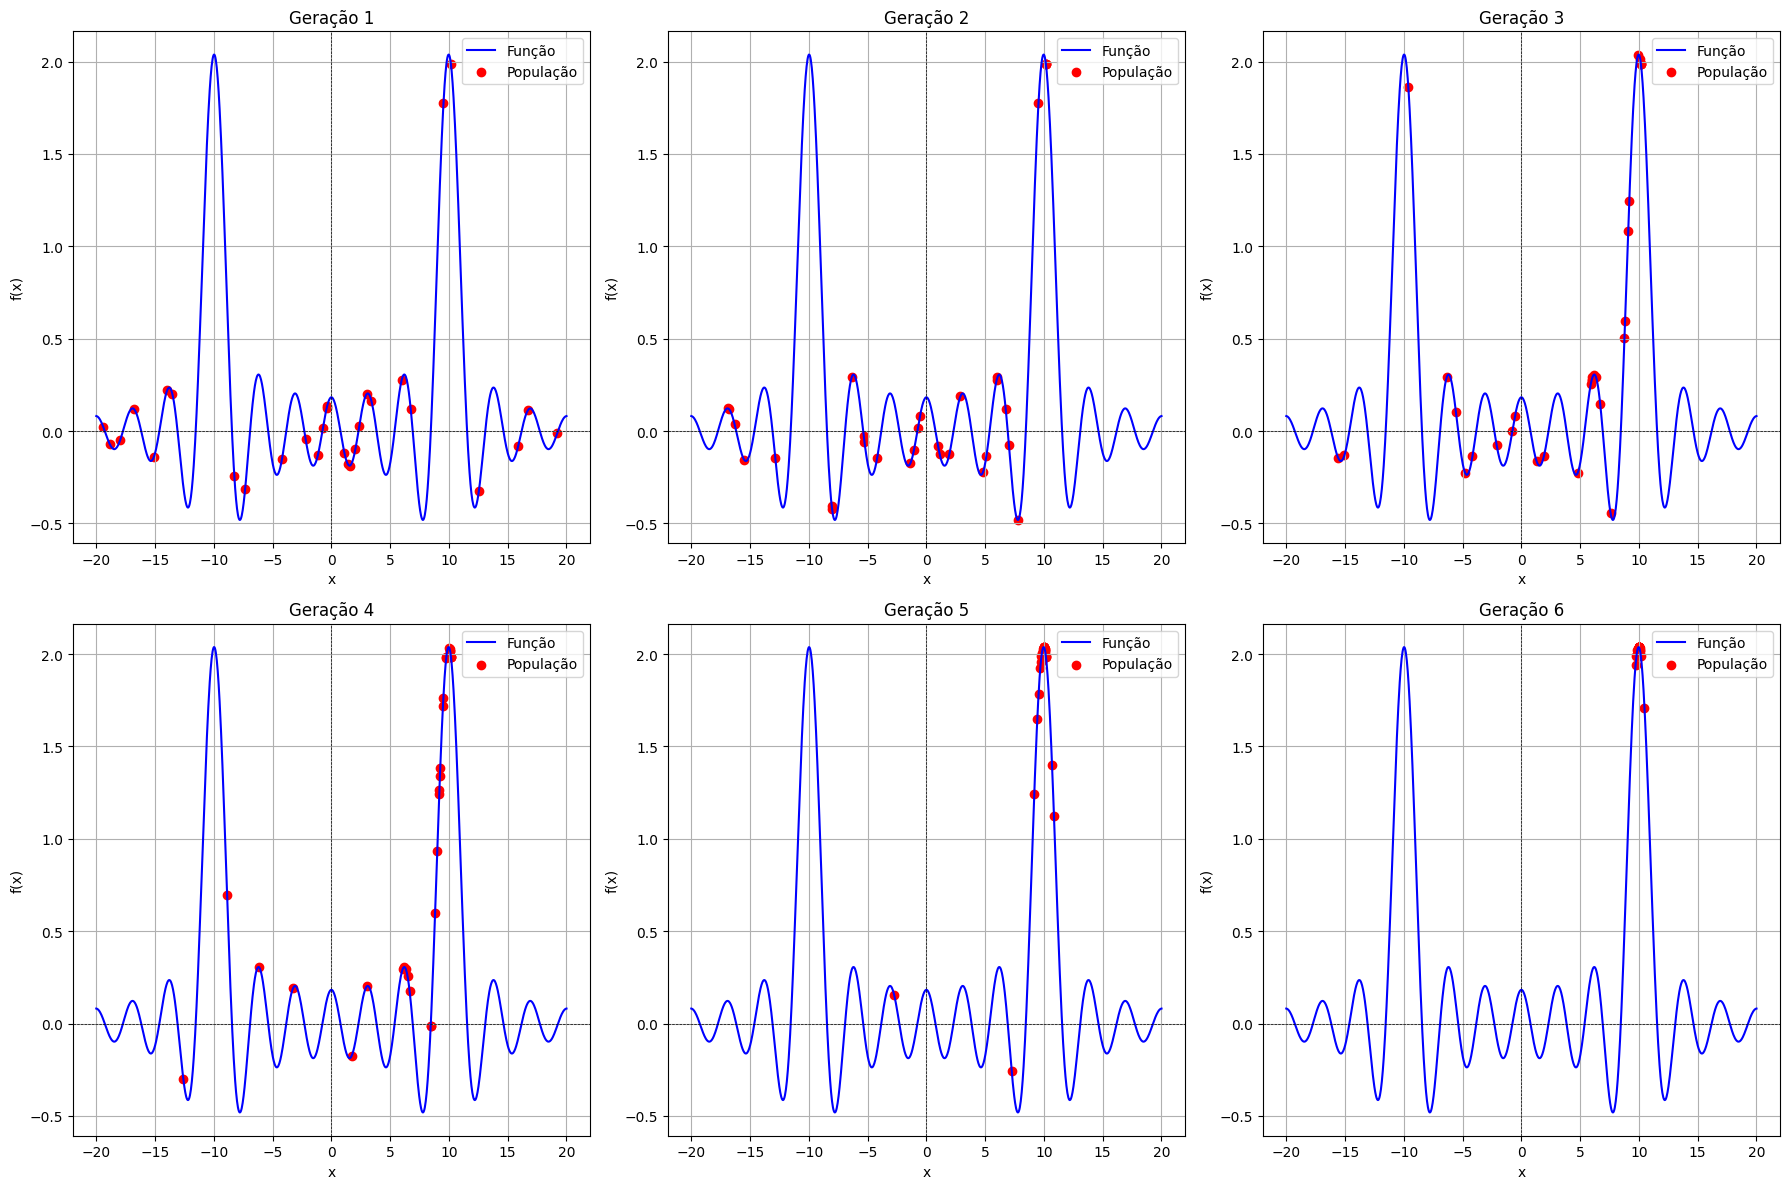

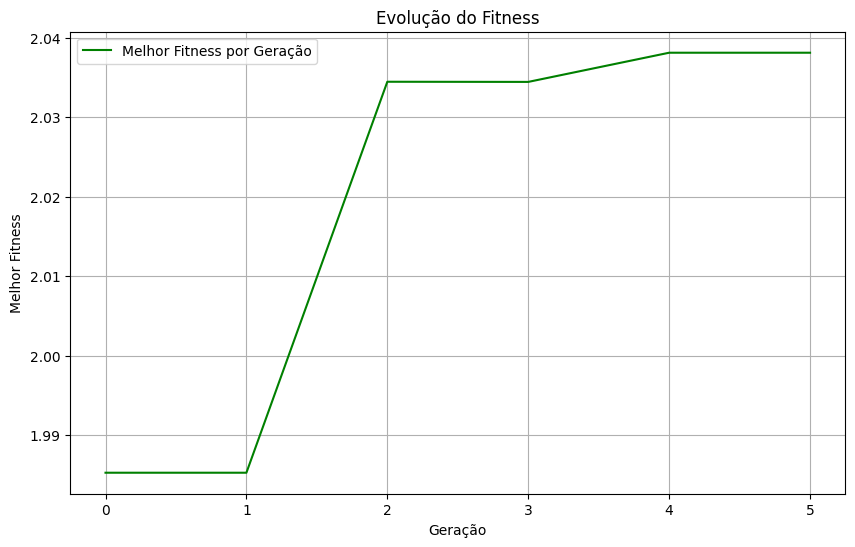

Implementação com Library DEAP
Melhor solução encontrada: x = -10.129132689742724, f(x) = 2.005167052318826


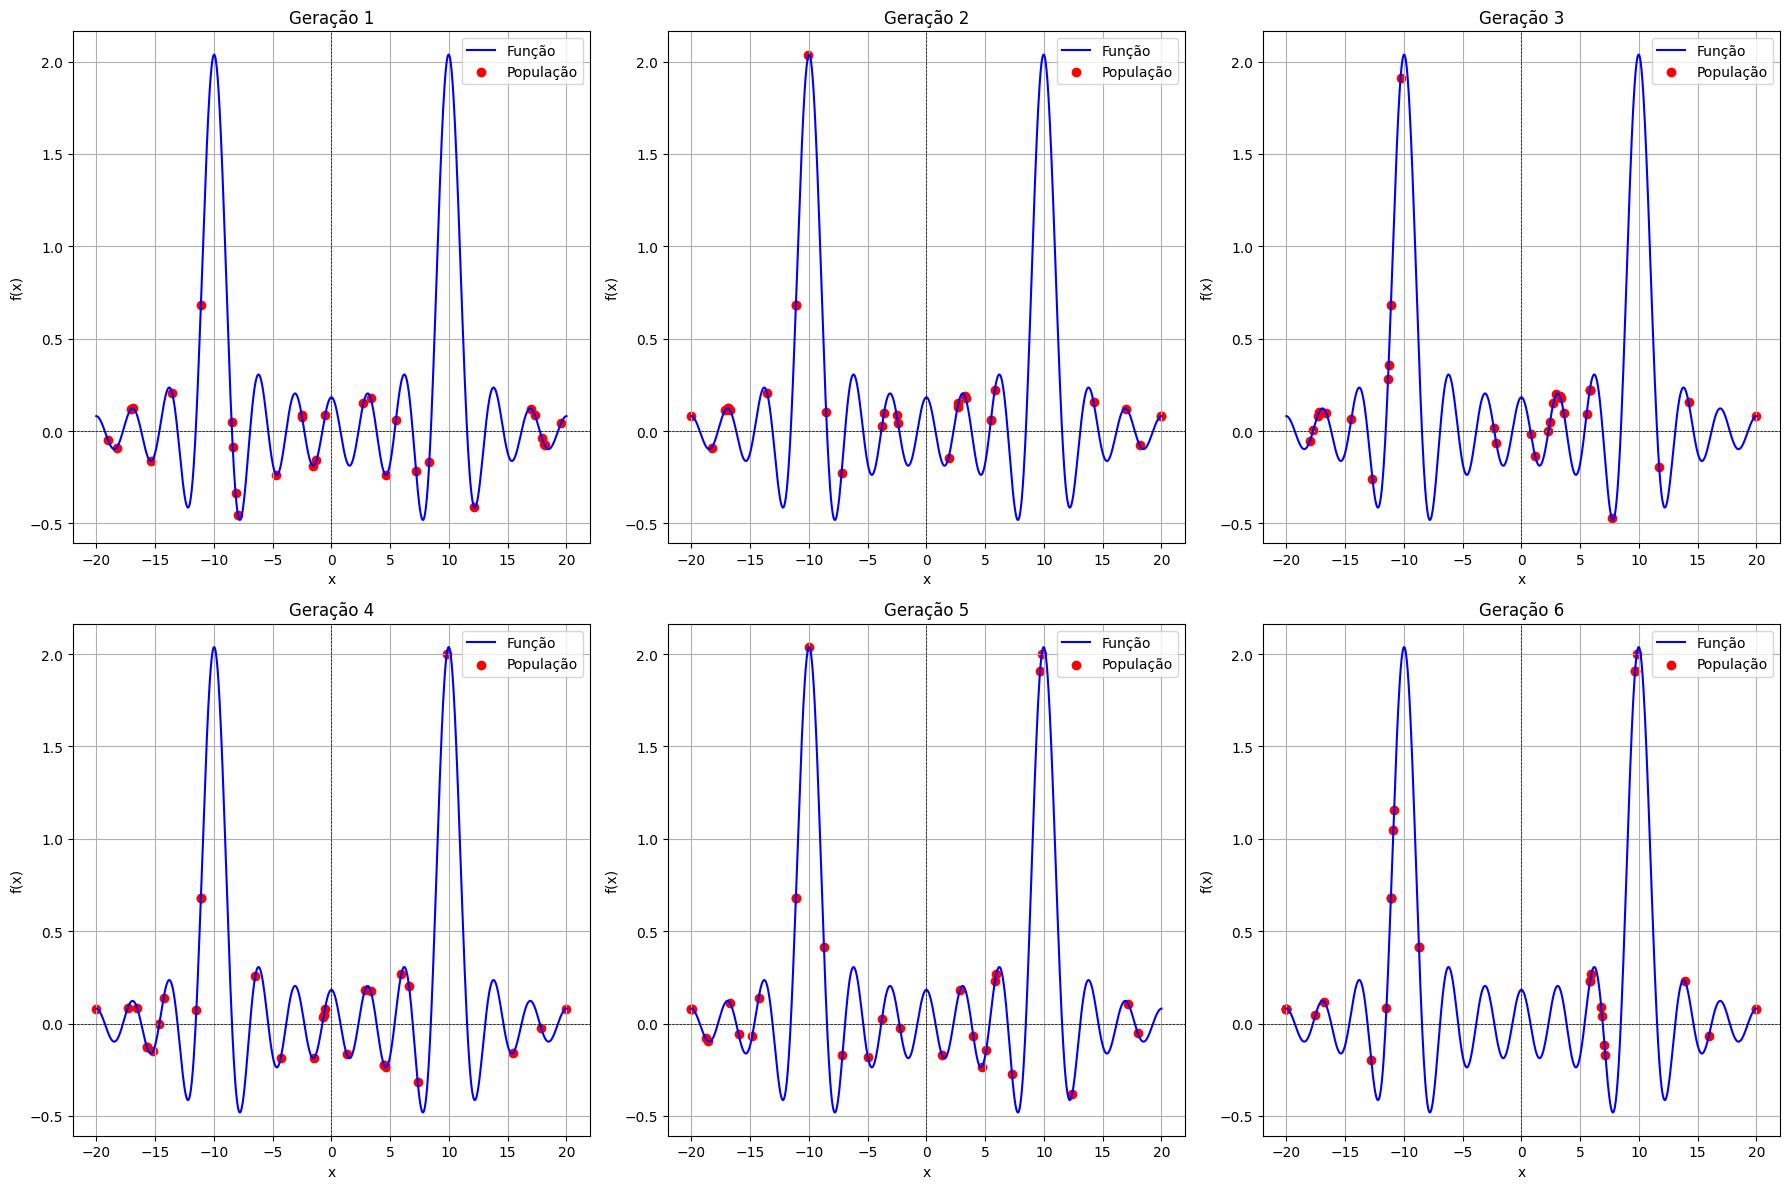

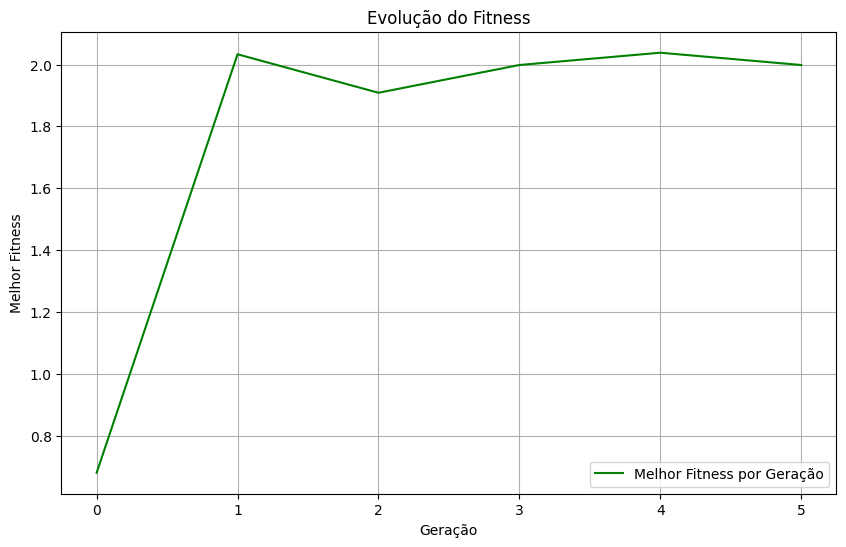

In [5]:
def f(x):
    return sinc(x-10) + sinc(x+10)

print("Implementação Simplificada")
run_ga(function=f, interval=[-20, 20])

print("Implementação com Library DEAP")
run_ga_deap(function=f, interval=[-20, 20])

### Função com Armadilha

$$
f(x)=\begin{cases}
4-x, &\text{se }x\in[0,4], \\
5x-20, &\text{se }x\in[4,5].
\end{cases}
$$

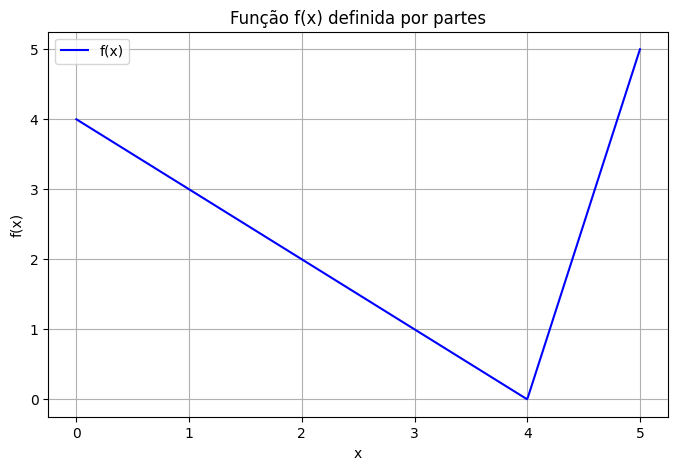

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def trap(x):
    return np.where(x <= 4, 4 - x, 5 * x - 20)

# Geração de pontos para o gráfico da função
x_vals = np.linspace(0, 5, 500)
y_vals = trap(x_vals)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x_vals, y_vals, label='f(x)', color='blue')
plt.title('Função f(x) definida por partes')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
plt.legend()
plt.show()

Implementação Simplificada
Melhor solução encontrada: x = 0.0, f(x) = 4.0


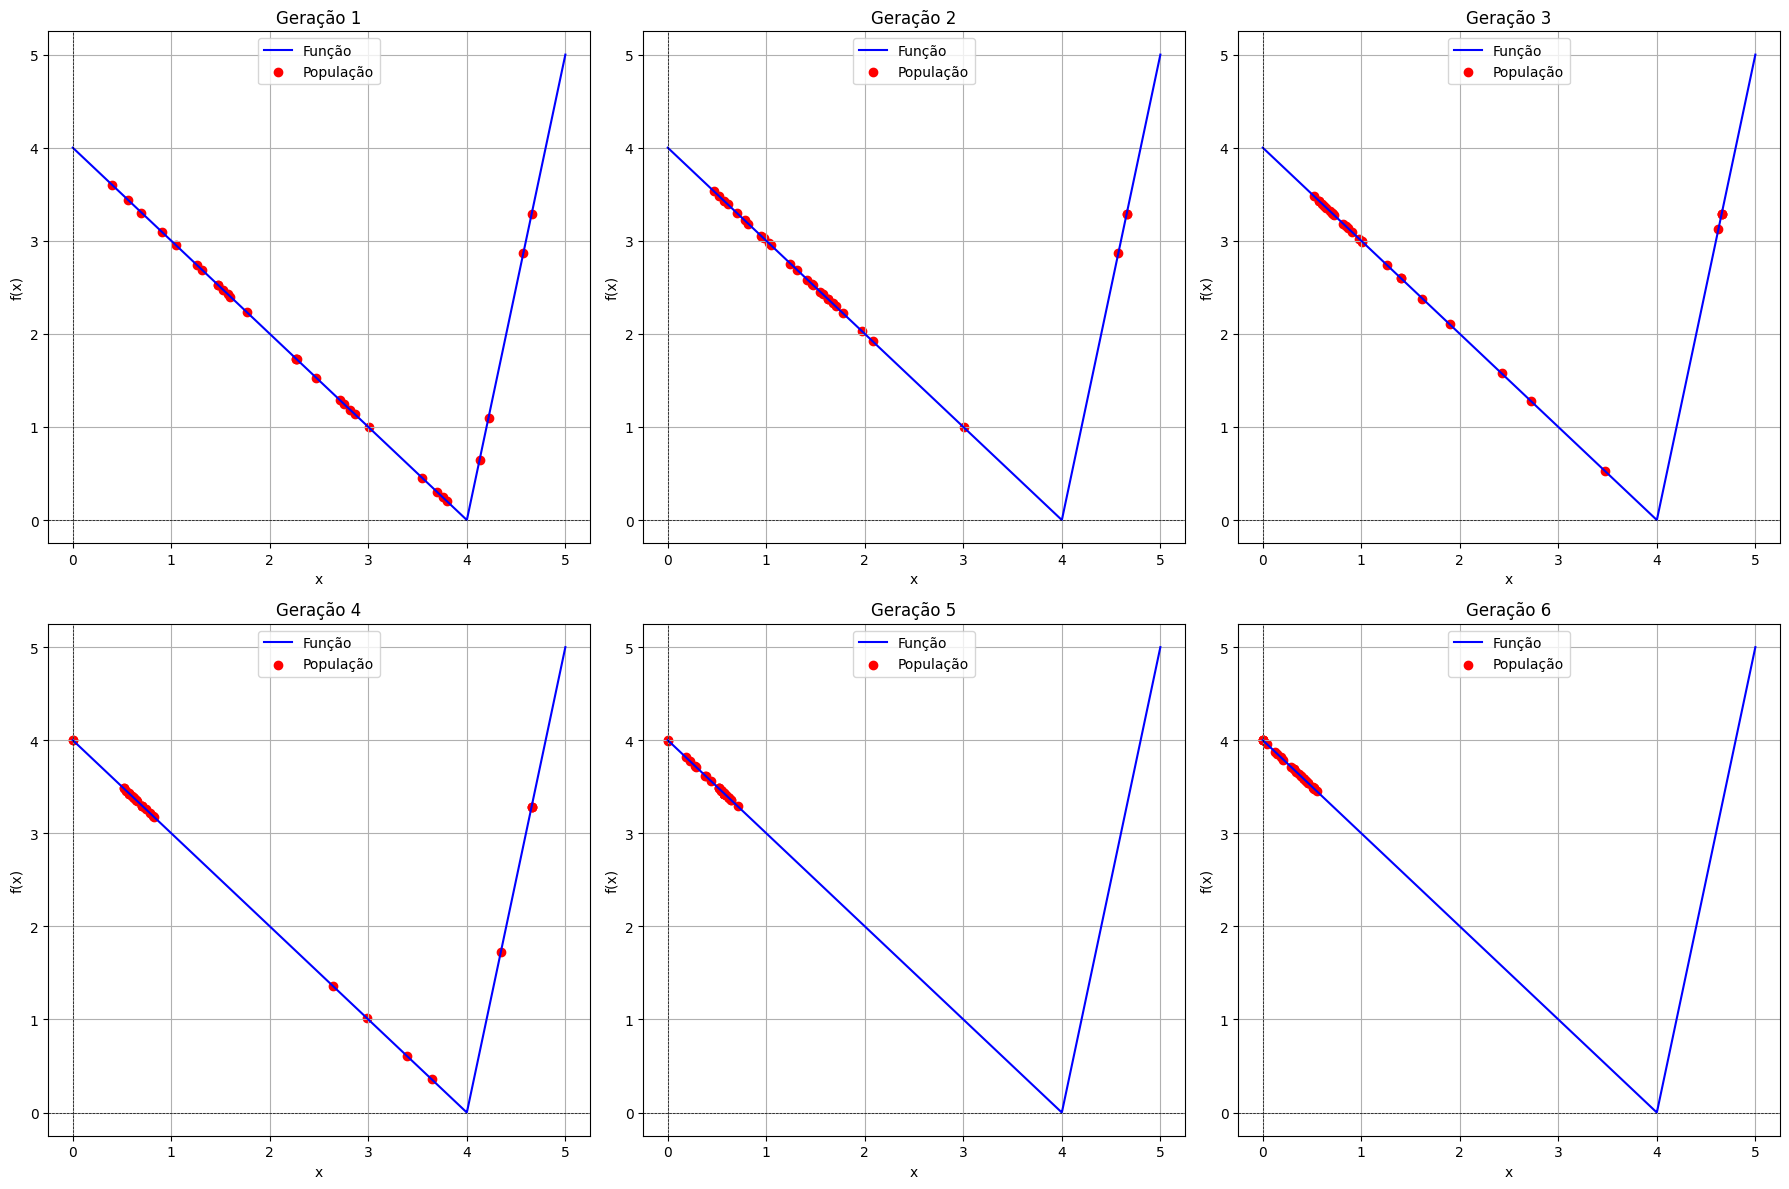

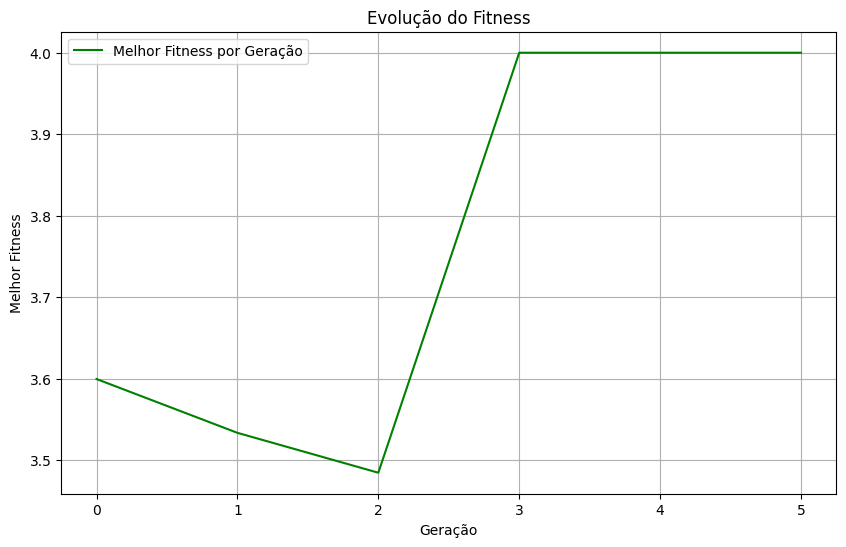

Implementação com Library DEAP
Melhor solução encontrada: x = 5.0, f(x) = 5.0


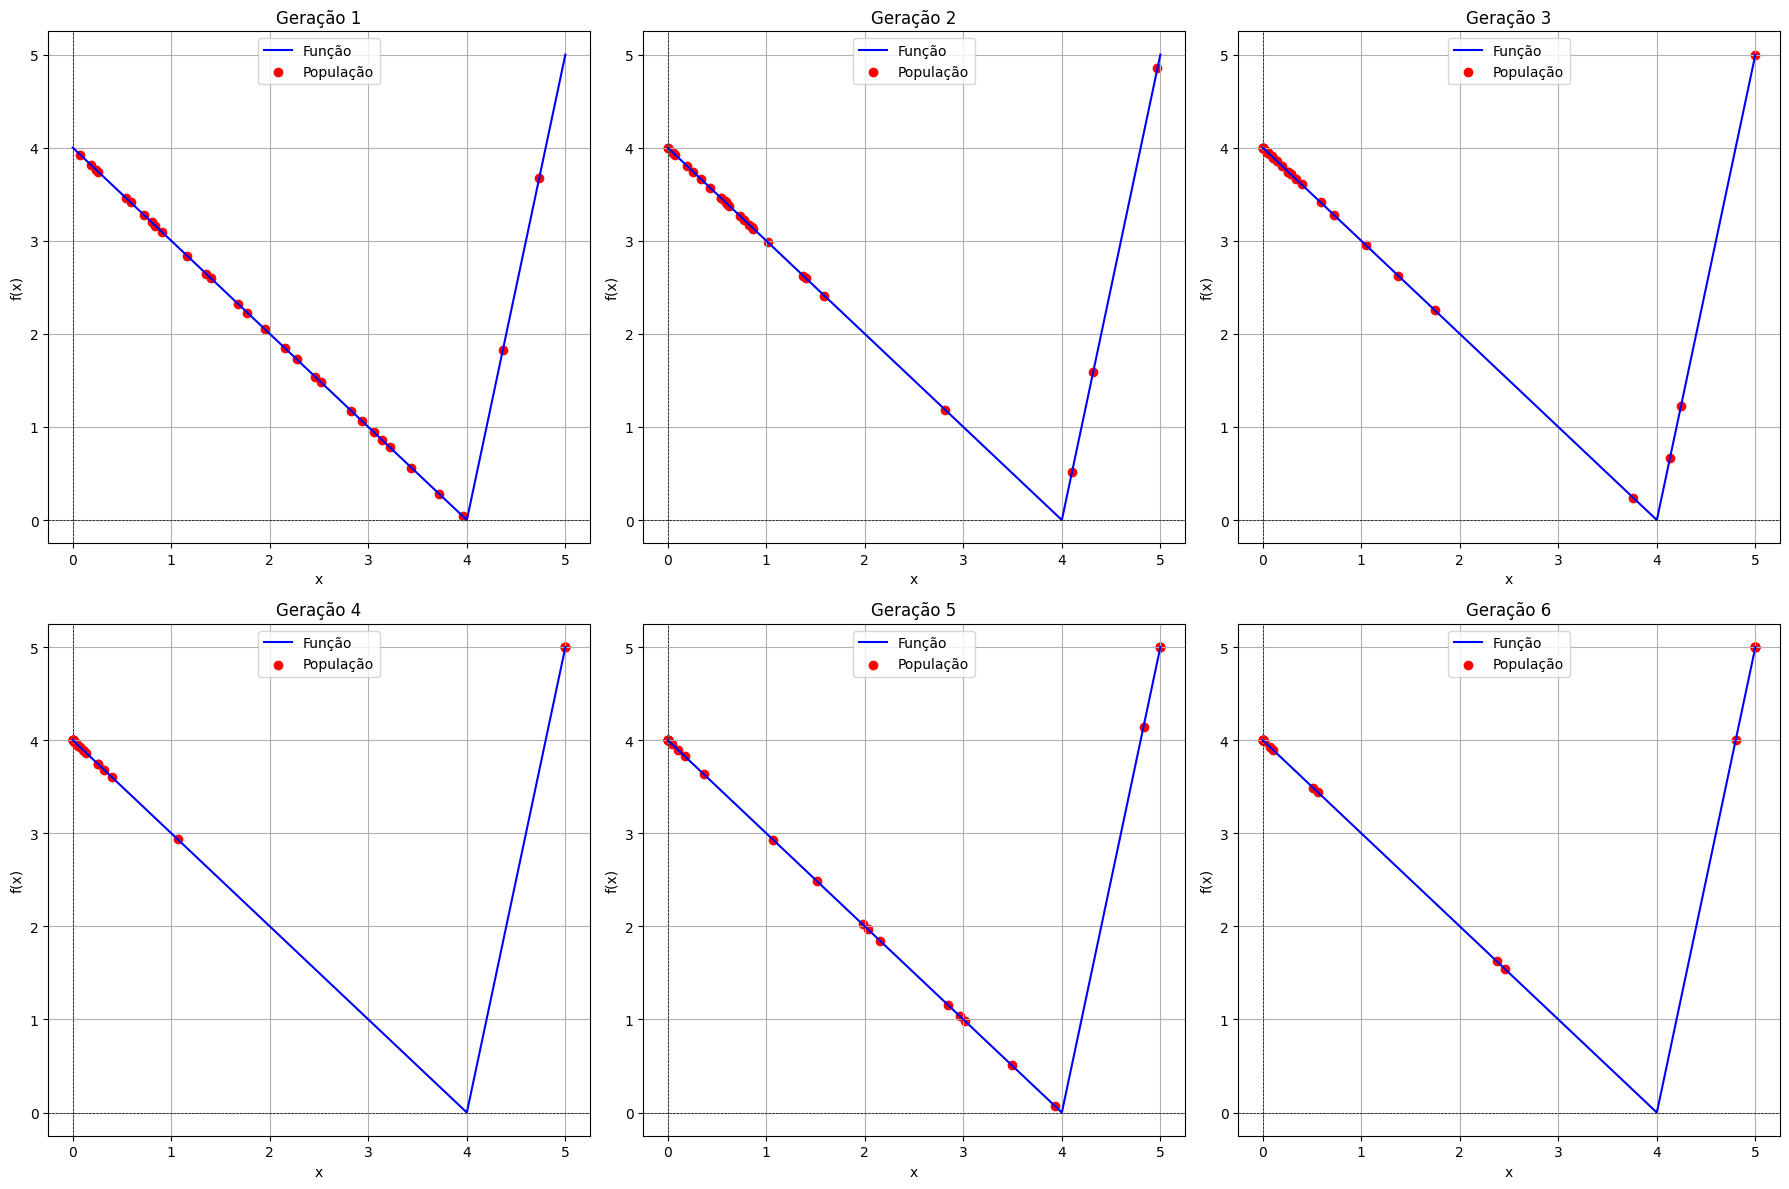

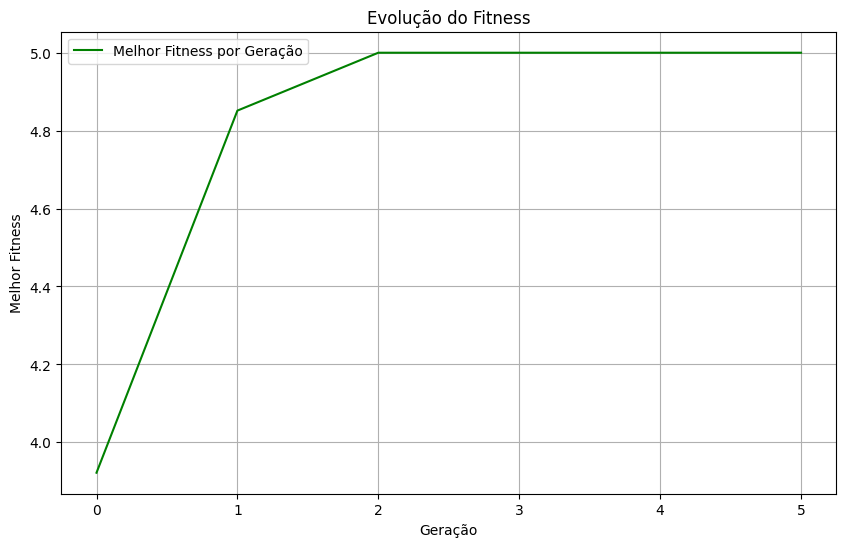

In [7]:
print("Implementação Simplificada")
run_ga(function=trap, interval=[0, 5])

print("Implementação com Library DEAP")
run_ga_deap(function=trap, interval=[0, 5])